Generating word clouds and category analysis...

Top terms by category for all reviews:

Quality:
  great: 1389
  good: 1225
  perfect: 237
  excellent: 214
  solid: 143

Performance:
  fast: 257
  quick: 99
  slow: 65
  smooth: 45
  powerful: 40

Reliability:
  stable: 42
  broke: 39
  failed: 35
  broken: 21
  died: 19

Value:
  worth: 195
  cheap: 115
  expensive: 106
  reasonable: 51
  affordable: 23

Emotional:
  love: 467
  happy: 188
  impressed: 81
  pleased: 75
  disappointed: 50

Usability:
  easy: 649
  simple: 135
  difficult: 81
  convenient: 44
  awkward: 22


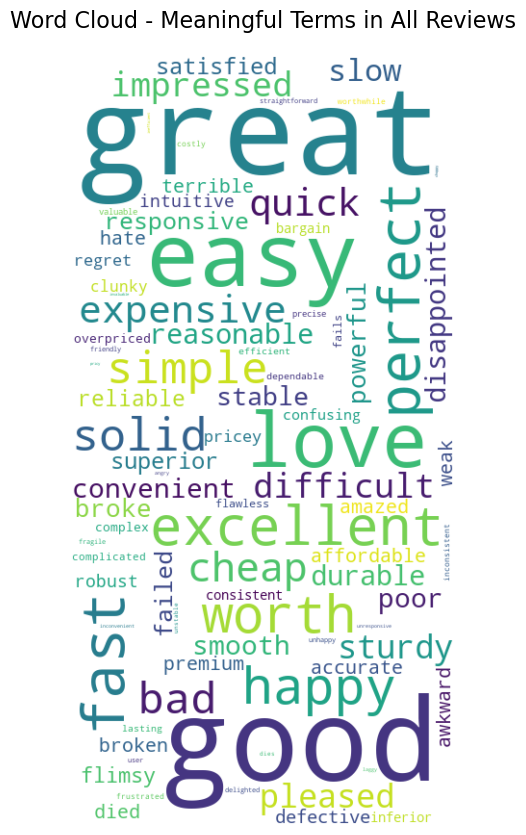


Top terms by category for positive reviews:

Quality:
  great: 1358
  good: 1171
  perfect: 234
  excellent: 214
  solid: 138

Performance:
  fast: 229
  quick: 91
  slow: 56
  smooth: 42
  powerful: 38

Reliability:
  stable: 40
  failed: 26
  broke: 22
  broken: 17
  died: 11

Value:
  worth: 183
  expensive: 97
  cheap: 92
  reasonable: 42
  affordable: 23

Emotional:
  love: 456
  happy: 181
  impressed: 81
  pleased: 72
  disappointed: 41

Usability:
  easy: 625
  simple: 128
  difficult: 68
  convenient: 40
  awkward: 19


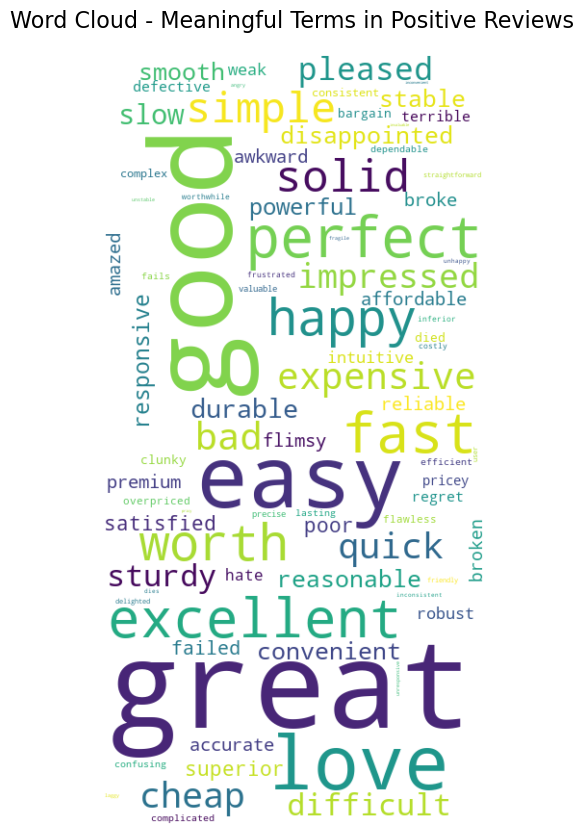


Top terms by category for negative reviews:

Quality:
  good: 46
  bad: 29
  great: 28
  cheap: 16
  poor: 16

Performance:
  fast: 16
  slow: 8
  quick: 6
  weak: 4
  powerful: 2

Reliability:
  broke: 14
  failed: 8
  died: 8
  broken: 4
  stable: 2

Value:
  cheap: 16
  worth: 12
  expensive: 6
  reasonable: 4
  pricey: 2

Emotional:
  love: 11
  disappointed: 9
  happy: 7
  hate: 5
  pleased: 3

Usability:
  easy: 20
  difficult: 13
  simple: 6
  confusing: 5
  awkward: 3


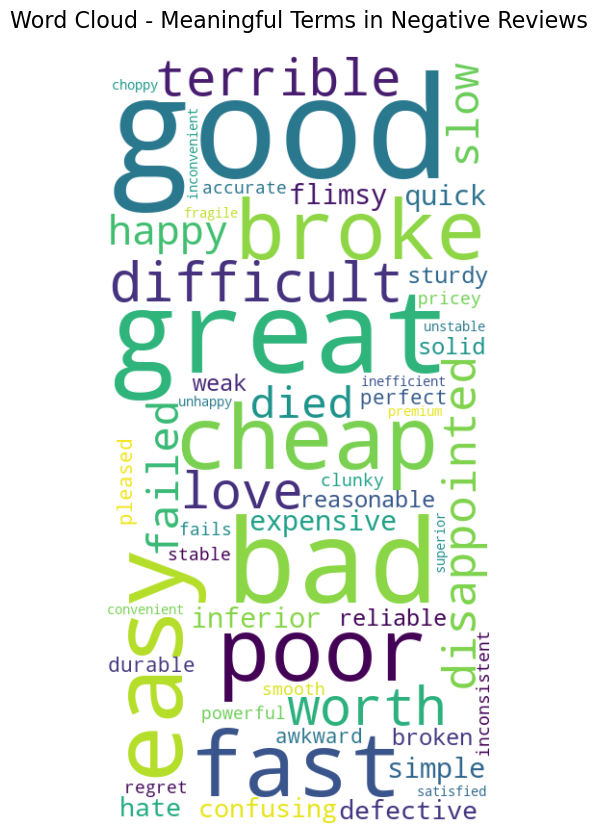

In [13]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from collections import Counter

def create_focused_wordcloud(input_file, sentiment=None):
    """
    Create a word cloud focusing only on meaningful descriptive terms using a whitelist approach.
    
    Parameters:
    input_file (str): Path to the CSV file
    sentiment (str): Optional - 'positive' or 'negative' to filter by sentiment
    """
    # Read the dataset
    df = pd.read_csv(input_file)
    
    # Filter by sentiment if specified
    if sentiment:
        df = df[df['sentiment'] == sentiment]
    
    # Define whitelisted terms by category
    whitelist = {
        'quality': {
            'excellent', 'poor', 'terrible', 'great', 'good', 'bad', 'superior',
            'inferior', 'perfect', 'flawless', 'defective', 'solid', 'weak',
            'premium', 'cheap', 'reliable', 'unreliable', 'durable', 'flimsy',
            'robust', 'sturdy', 'fragile'
        },
        'performance': {
            'fast', 'slow', 'quick', 'laggy', 'responsive', 'unresponsive',
            'smooth', 'choppy', 'efficient', 'inefficient', 'powerful',
            'weak', 'consistent', 'inconsistent', 'accurate', 'inaccurate',
            'precise', 'imprecise'
        },
        'reliability': {
            'broke', 'broken', 'lasting', 'failed', 'fails', 'stable',
            'unstable', 'consistent', 'inconsistent', 'dependable',
            'undependable', 'trustworthy', 'unreliable', 'dies', 'died'
        },
        'value': {
            'expensive', 'overpriced', 'cheap', 'reasonable', 'worth',
            'worthwhile', 'bargain', 'costly', 'affordable', 'unaffordable',
            'valuable', 'invaluable', 'pricey', 'pricy'
        },
        'emotional': {
            'love', 'hate', 'disappointed', 'satisfied', 'happy', 'unhappy',
            'pleased', 'displeased', 'amazed', 'frustrated', 'angry',
            'delighted', 'regret', 'impressed', 'unimpressed'
        },
        'usability': {
            'easy', 'difficult', 'simple', 'complicated', 'intuitive',
            'confusing', 'straightforward', 'complex', 'convenient',
            'inconvenient', 'user-friendly', 'clunky', 'awkward'
        }
    }
    
    # Combine all whitelisted terms
    all_whitelist_terms = set().union(*whitelist.values())
    
    def extract_whitelisted_words(text):
        """Extract only whitelisted words from text."""
        words = text.lower().split()
        return ' '.join(word for word in words if word in all_whitelist_terms)
    
    # Process all reviews and combine whitelisted words
    text = ' '.join(df['review_text'].dropna().astype(str).apply(extract_whitelisted_words))
    
    # Create word frequencies
    word_freq = Counter(text.split())
    
    # Print top terms by category
    print(f"\nTop terms by category for {sentiment if sentiment else 'all'} reviews:")
    for category, terms in whitelist.items():
        category_words = {word: count for word, count in word_freq.items() if word in terms}
        if category_words:
            print(f"\n{category.title()}:")
            sorted_words = sorted(category_words.items(), key=lambda x: x[1], reverse=True)
            for word, count in sorted_words[:5]:  # Top 5 words in each category
                print(f"  {word}: {count}")
    
    # Create and configure the WordCloud object
    wordcloud = WordCloud(
        height=800,
        background_color='white',
        max_words=100,
        collocations=False,
        contour_width=3,
        contour_color='steelblue'
    )
    
    # Generate word cloud
    wordcloud = wordcloud.generate(text)
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    # Add title based on sentiment
    title = "Word Cloud - Meaningful Terms in "
    title += f"{sentiment.capitalize()} Reviews" if sentiment else "All Reviews"
    plt.title(title, fontsize=16, pad=20)
    
    plt.show()


input_file = "../data/processed/final_sentiment_analysis_data.csv"

# Generate word clouds and print category analysis
print("Generating word clouds and category analysis...")

# All reviews
create_focused_wordcloud(input_file)

# Positive reviews only
create_focused_wordcloud(input_file, sentiment='positive')

# Negative reviews only
create_focused_wordcloud(input_file, sentiment='negative')

Key Insights:

1. Overall Sentiment Words
- Most common positive descriptors: "great" (1389) and "good" (1225) dominate
- "Love" appears frequently (467 times), suggesting strong positive emotional responses
- "Easy" is very common (649 times), indicating usability is a major factor

1. Quality vs Performance
- Quality terms are used much more frequently than performance terms
- "Great" (1389) vs "Fast" (257) shows people comment on general quality more than specific performance
- "Perfect" (237) and "Excellent" (214) suggest many highly satisfied customers

1. Reliability Issues
- Relatively low counts for reliability terms
- Only 42 mentions of "stable"
- Similar low counts for problems: "broke" (39), "failed" (35), "broken" (21)
- This might suggest reliability isn't a major concern

1. Value Propositions
- "Worth" (195) is the most common value term
- Balance between "cheap" (115) and "expensive" (106)
- Fewer mentions of "affordable" (23) might indicate price isn't the primary focus

1. User Experience
- Strong emphasis on ease of use: "easy" (649)
- "Simple" (135) reinforces the usability focus
- Relatively few negative usability terms: "difficult" (81), "awkward" (22)

These numbers suggest that:
1. Most reviews focus on general quality and ease of use
2. Strong emotional responses are common (especially positive ones)
3. Performance and reliability issues aren't frequently mentioned
4. Price/value discussions are present but not dominant


Top terms for negative reviews:

Negative Terms:
  bad: 34
  poor: 17
  difficult: 15
  terrible: 14
  slow: 12

Negated Positive Terms:
  NEG_good: 30
  NEG_great: 16
  NEG_easy: 9
  NEG_worth: 8
  NEG_fast: 5


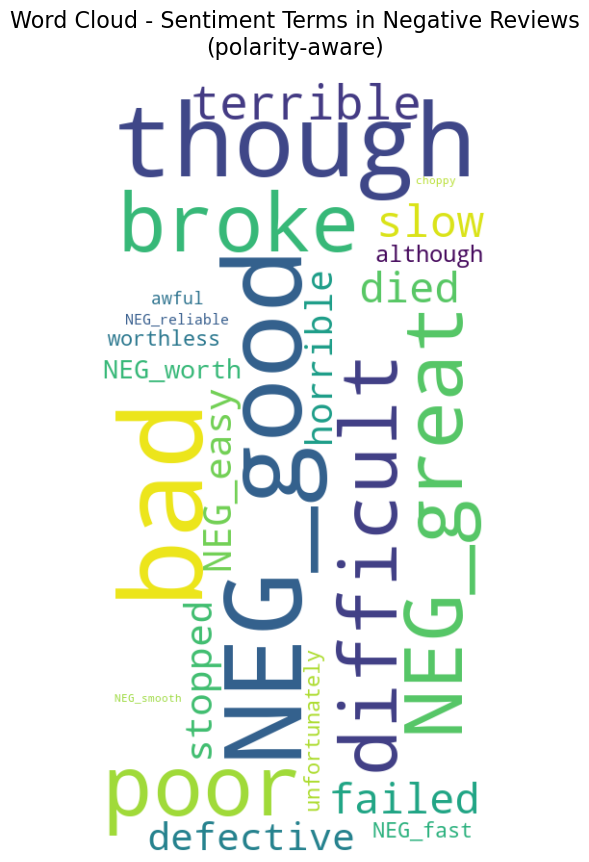

In [21]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re

def create_polarity_aware_wordcloud(input_file, sentiment=None):
    """
    Create a word cloud that properly handles sentiment polarity in context.
    
    Parameters:
    input_file (str): Path to the CSV file
    sentiment (str): Optional - 'positive' or 'negative' to filter by sentiment
    """
    # Read the dataset
    df = pd.read_csv(input_file)
    
    # Filter by sentiment if specified
    if sentiment:
        df = df[df['sentiment'] == sentiment]
    
    # Define sentiment words with polarity
    positive_words = {
        'good', 'great', 'excellent', 'perfect', 'awesome', 'wonderful',
        'fast', 'reliable', 'worth', 'easy', 'smooth', 'responsive'
    }
    
    negative_words = {
        'bad', 'poor', 'terrible', 'horrible', 'awful', 'slow', 'unreliable',
        'worthless', 'difficult', 'choppy', 'unresponsive', 'defective'
    }
    
    # Define negation words
    negation_words = {
        'not', 'no', 'never', "isn't", "wasn't", "aren't", "don't",
        "doesn't", "won't", "can't", "couldn't", "wouldn't", "shouldn't"
    }
    
    # Define context modifiers
    context_modifiers = {
        'but', 'however', 'although', 'though', 'unfortunately',
        'until', 'broke', 'failed', 'stopped', 'died'
    }
    
    def process_review_polarity(text):
        """Process text with polarity awareness."""
        text = text.lower()
        sentences = re.split(r'[.!?]+', text)
        result = []
        
        for sentence in sentences:
            words = sentence.split()
            if not words:
                continue
            
            # Initialize processing flags
            neg_window = 0
            has_context_modifier = any(word in context_modifiers for word in words)
            
            processed_words = []
            for i, word in enumerate(words):
                if word in negation_words:
                    neg_window = 3
                    continue  # Skip negation words in output
                
                # Handle sentiment words based on context
                if word in positive_words:
                    if sentiment == 'negative':
                        if neg_window > 0 or has_context_modifier:
                            processed_words.append(f"NEG_{word}")
                        # Skip positive words in negative reviews unless negated
                    neg_window = max(0, neg_window - 1)
                elif word in negative_words:
                    if neg_window > 0:
                        # Skip negated negative words (double negative)
                        neg_window = max(0, neg_window - 1)
                    else:
                        processed_words.append(word)
                elif word in context_modifiers:
                    # Keep context modifiers for reference
                    processed_words.append(word)
                else:
                    if neg_window > 0:
                        neg_window = max(0, neg_window - 1)
            
            if processed_words:
                result.extend(processed_words)
        
        return ' '.join(result)
    
    # Process all reviews
    processed_text = ' '.join(df['review_text'].dropna().astype(str).apply(process_review_polarity))
    
    # Create word frequencies
    words = processed_text.split()
    word_freq = Counter(word for word in words 
                       if word in positive_words or 
                       word in negative_words or
                       (word.startswith('NEG_') and word[4:] in positive_words))
    
    # Print frequencies by category
    print(f"\nTop terms for {sentiment if sentiment else 'all'} reviews:")
    print("\nNegative Terms:")
    neg_terms = {word: count for word, count in word_freq.items() 
                if word in negative_words}
    for word, count in sorted(neg_terms.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {word}: {count}")
        
    print("\nNegated Positive Terms:")
    negated_pos_terms = {word: count for word, count in word_freq.items() 
                        if word.startswith('NEG_')}
    for word, count in sorted(negated_pos_terms.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {word}: {count}")
    
    # Create and configure the WordCloud object
    wordcloud = WordCloud(
        height=800,
        background_color='white',
        max_words=100,
        collocations=False,
        contour_width=3,
        contour_color='steelblue'
    )
    
    # Generate word cloud
    wordcloud = wordcloud.generate(processed_text)
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    # Add title
    title = "Word Cloud - Sentiment Terms in "
    title += f"{sentiment.capitalize() if sentiment else 'All'} Reviews\n(polarity-aware)"
    plt.title(title, fontsize=16, pad=20)
    
    plt.show()

# Example usage
input_file = "../data/processed/final_sentiment_analysis_data.csv"

# Generate word cloud for negative reviews
create_polarity_aware_wordcloud(input_file, sentiment='negative')

In [15]:
import pandas as pd
from collections import Counter
from tabulate import tabulate

def compare_sentiment_terms(input_file):
    """
    Compare term frequencies between positive and negative reviews.
    
    Parameters:
    input_file (str): Path to the CSV file
    """
    # Read the dataset
    df = pd.read_csv(input_file)
    
    # Define categories and their terms
    categories = {
        'Quality': {
            'excellent', 'poor', 'terrible', 'great', 'good', 'bad', 'superior',
            'inferior', 'perfect', 'flawless', 'defective', 'solid', 'weak',
            'premium', 'cheap', 'reliable', 'unreliable', 'durable', 'flimsy',
            'robust', 'sturdy', 'fragile'
        },
        'Performance': {
            'fast', 'slow', 'quick', 'laggy', 'responsive', 'unresponsive',
            'smooth', 'choppy', 'efficient', 'inefficient', 'powerful',
            'weak', 'consistent', 'inconsistent', 'accurate', 'inaccurate'
        },
        'Reliability': {
            'broke', 'broken', 'lasting', 'failed', 'fails', 'stable',
            'unstable', 'consistent', 'inconsistent', 'dependable',
            'undependable', 'trustworthy', 'unreliable', 'dies', 'died'
        },
        'Value': {
            'expensive', 'overpriced', 'cheap', 'reasonable', 'worth',
            'worthwhile', 'bargain', 'costly', 'affordable', 'unaffordable',
            'valuable', 'invaluable', 'pricey', 'pricy'
        },
        'Emotional': {
            'love', 'hate', 'disappointed', 'satisfied', 'happy', 'unhappy',
            'pleased', 'displeased', 'amazed', 'frustrated', 'angry',
            'delighted', 'regret', 'impressed', 'unimpressed'
        },
        'Usability': {
            'easy', 'difficult', 'simple', 'complicated', 'intuitive',
            'confusing', 'straightforward', 'complex', 'convenient',
            'inconvenient', 'user-friendly', 'clunky', 'awkward'
        }
    }
    
    # Get word frequencies for positive and negative reviews
    pos_reviews = df[df['sentiment'] == 'positive']['review_text'].str.lower()
    neg_reviews = df[df['sentiment'] == 'negative']['review_text'].str.lower()
    
    pos_words = ' '.join(pos_reviews.dropna()).split()
    neg_words = ' '.join(neg_reviews.dropna()).split()
    
    pos_freq = Counter(pos_words)
    neg_freq = Counter(neg_words)
    
    # Calculate total words in each sentiment
    total_pos = len(pos_words)
    total_neg = len(neg_words)
    
    # Prepare comparison data
    comparison_data = []
    
    print("\nComparison of Positive vs Negative Reviews\n")
    print(f"Total words in positive reviews: {total_pos:,}")
    print(f"Total words in negative reviews: {total_neg:,}\n")
    
    for category, terms in categories.items():
        print(f"\n{category} Terms:")
        print("-" * 80)
        print(f"{'Term':<15} {'Positive':<12} {'Negative':<12} {'Pos %':<10} {'Neg %':<10} {'Ratio +/-'}")
        print("-" * 80)
        
        for term in terms:
            pos_count = pos_freq[term]
            neg_count = neg_freq[term]
            
            if pos_count + neg_count > 0:  # Only show terms that appear
                pos_pct = (pos_count / total_pos) * 10000  # Per 10,000 words
                neg_pct = (neg_count / total_neg) * 10000  # Per 10,000 words
                
                # Calculate ratio (handle division by zero)
                if neg_count == 0:
                    ratio = float('inf')
                elif pos_count == 0:
                    ratio = 0
                else:
                    ratio = (pos_count / total_pos) / (neg_count / total_neg)
                
                if pos_count + neg_count >= 10:  # Only show terms with sufficient frequency
                    print(f"{term:<15} {pos_count:<12} {neg_count:<12} {pos_pct:>7.2f} {neg_pct:>9.2f} {ratio:>10.2f}")

input_file = "../data/processed/final_sentiment_analysis_data.csv"
compare_sentiment_terms(input_file)


Comparison of Positive vs Negative Reviews

Total words in positive reviews: 424,092
Total words in negative reviews: 34,781


Quality Terms:
--------------------------------------------------------------------------------
Term            Positive     Negative     Pos %      Neg %      Ratio +/-
--------------------------------------------------------------------------------
great           1358         28             32.02      8.05       3.98
durable         48           3               1.13      0.86       1.31
superior        30           1               0.71      0.29       2.46
terrible        13           11              0.31      3.16       0.10
cheap           92           16              2.17      4.60       0.47
poor            29           16              0.68      4.60       0.15
reliable        23           4               0.54      1.15       0.47
weak            16           4               0.38      1.15       0.33
perfect         234          3               5.52    


Sentiment Term Analysis Summary

Quality Category Analysis
--------------------------------------------------------------------------------
Term            Pos Count  Neg Count  Pos/10k    Neg/10k    Ratio
--------------------------------------------------------------------------------
great           1358       28            32.02      8.05       3.98
good            1171       46            27.61     13.23       2.09
perfect         234        3              5.52      0.86       6.40
excellent       214        0              5.05      0.00        inf
solid           138        4              3.25      1.15       2.83
bad             101        29             2.38      8.34       0.29
cheap           92         16             2.17      4.60       0.47
sturdy          69         4              1.63      1.15       1.41
durable         48         3              1.13      0.86       1.31
poor            29         16             0.68      4.60       0.15
superior        30         1    

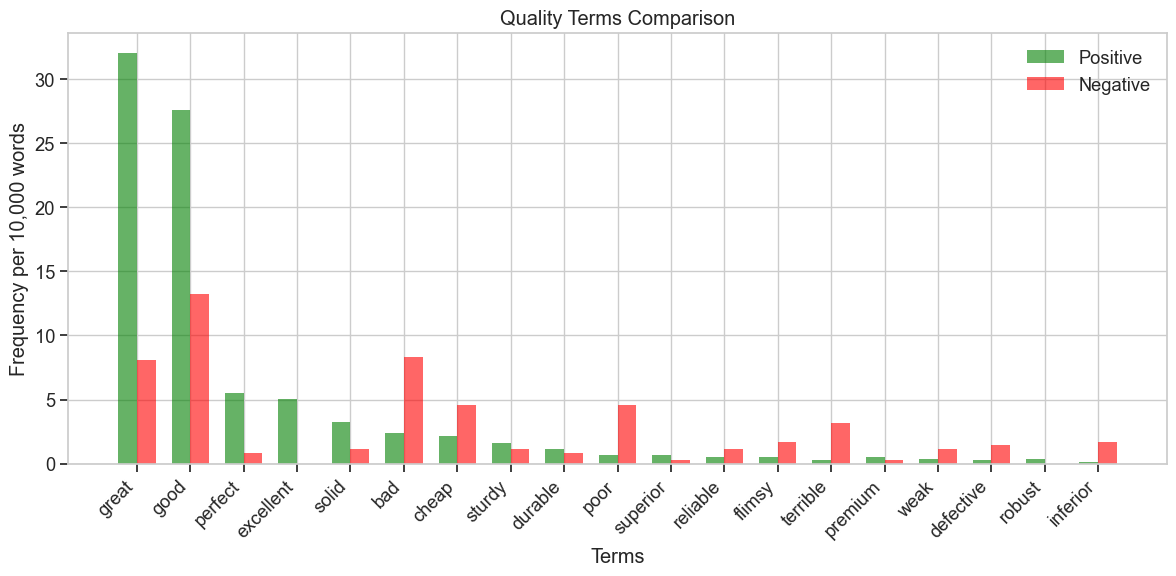

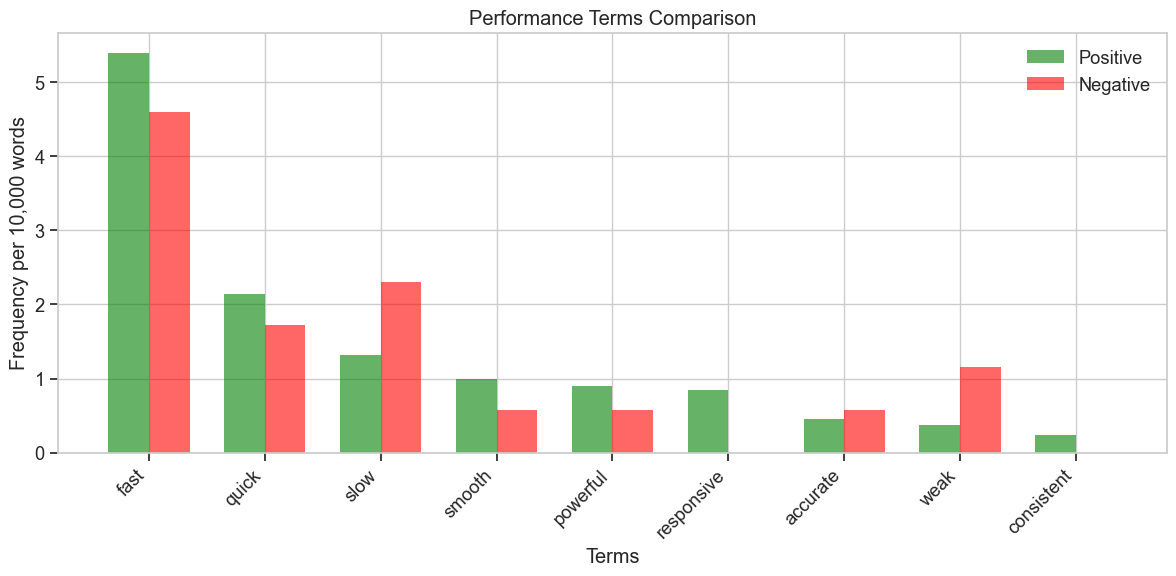

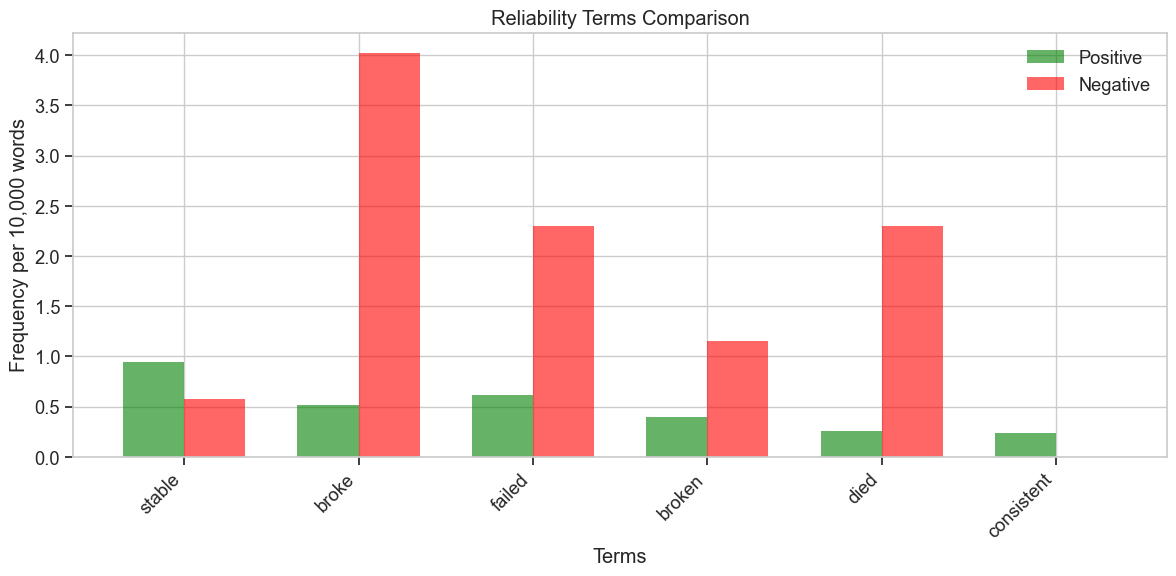

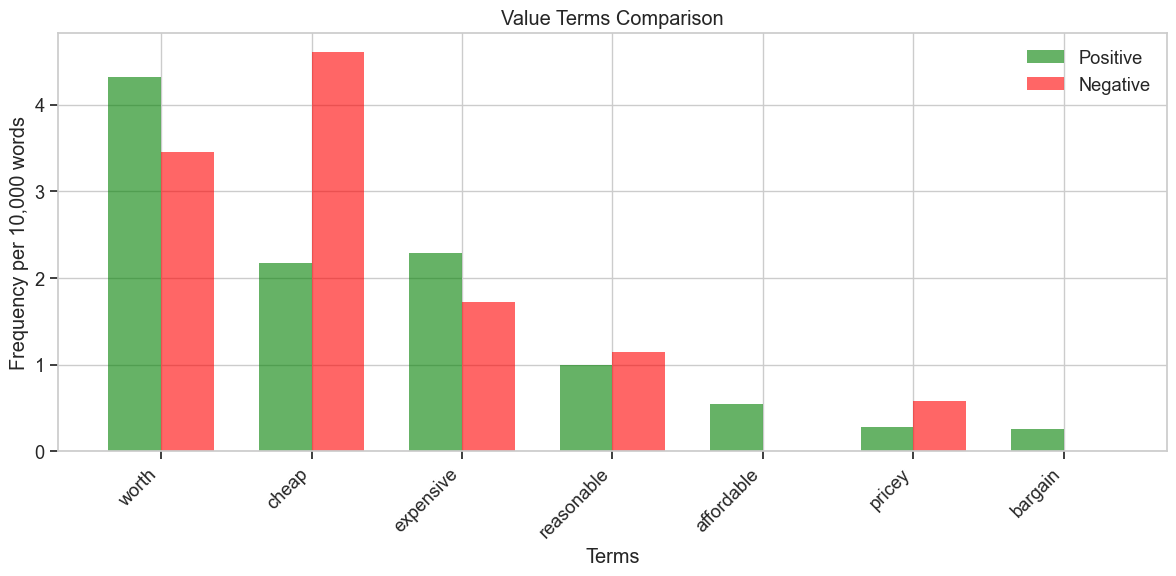

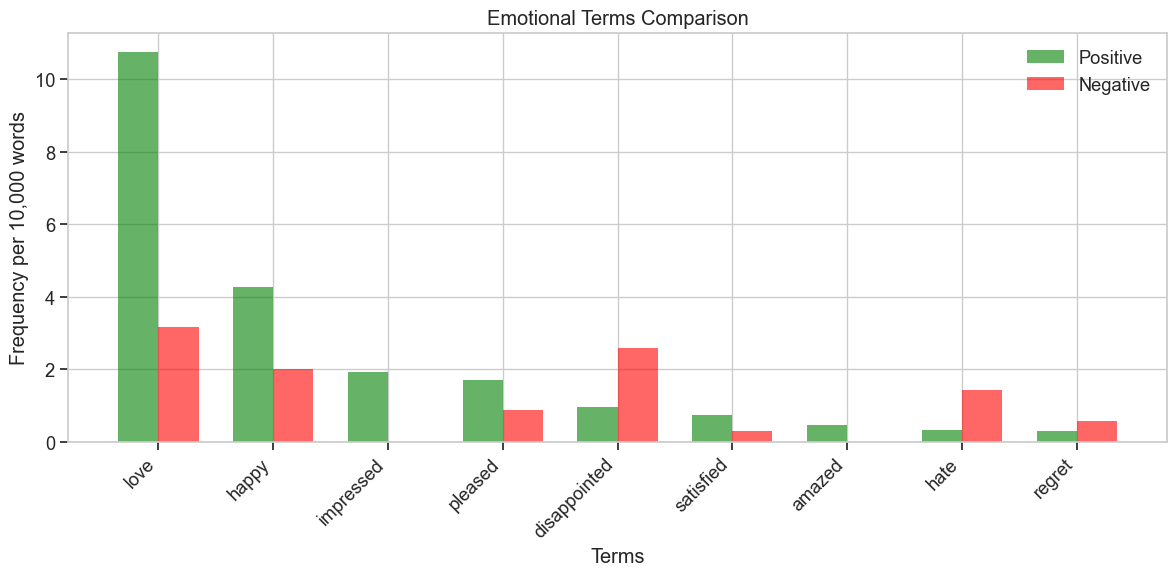

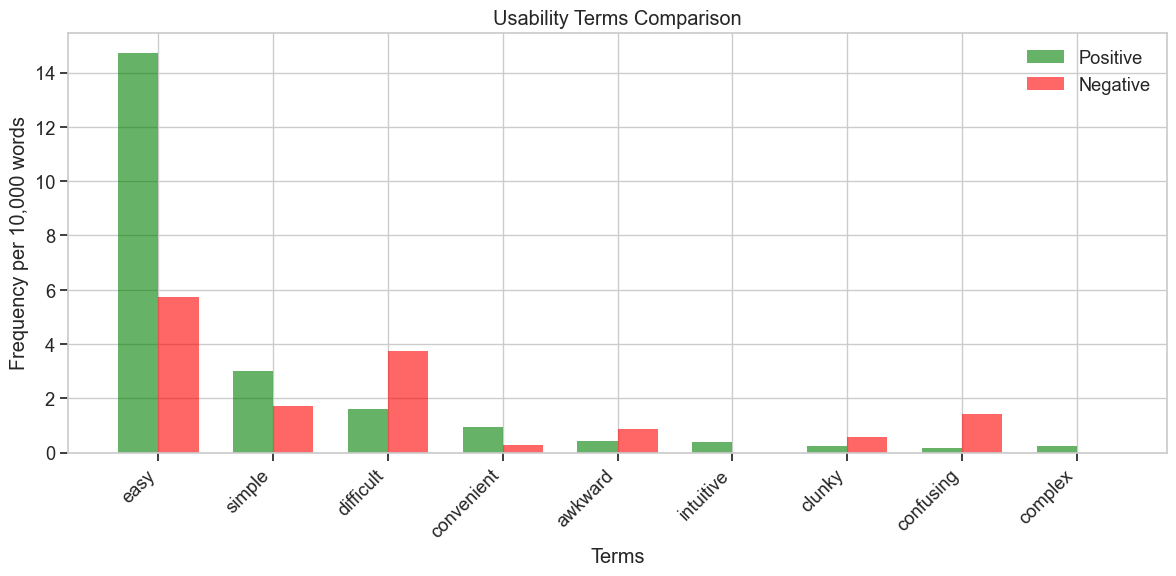

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from typing import Dict, Set, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

class SentimentTermAnalyzer:
    def __init__(self, input_file: str):
        """Initialize the analyzer with input file path and sentiment categories."""
        self.df = pd.read_csv(input_file)
        self.categories = {
            'Quality': {
                'excellent', 'poor', 'terrible', 'great', 'good', 'bad', 'superior',
                'inferior', 'perfect', 'flawless', 'defective', 'solid', 'weak',
                'premium', 'cheap', 'reliable', 'unreliable', 'durable', 'flimsy',
                'robust', 'sturdy', 'fragile'
            },
            'Performance': {
                'fast', 'slow', 'quick', 'laggy', 'responsive', 'unresponsive',
                'smooth', 'choppy', 'efficient', 'inefficient', 'powerful',
                'weak', 'consistent', 'inconsistent', 'accurate', 'inaccurate'
            },
            'Reliability': {
                'broke', 'broken', 'lasting', 'failed', 'fails', 'stable',
                'unstable', 'consistent', 'inconsistent', 'dependable',
                'undependable', 'trustworthy', 'unreliable', 'dies', 'died'
            },
            'Value': {
                'expensive', 'overpriced', 'cheap', 'reasonable', 'worth',
                'worthwhile', 'bargain', 'costly', 'affordable', 'unaffordable',
                'valuable', 'invaluable', 'pricey', 'pricy'
            },
            'Emotional': {
                'love', 'hate', 'disappointed', 'satisfied', 'happy', 'unhappy',
                'pleased', 'displeased', 'amazed', 'frustrated', 'angry',
                'delighted', 'regret', 'impressed', 'unimpressed'
            },
            'Usability': {
                'easy', 'difficult', 'simple', 'complicated', 'intuitive',
                'confusing', 'straightforward', 'complex', 'convenient',
                'inconvenient', 'user-friendly', 'clunky', 'awkward'
            }
        }
        
    def preprocess_reviews(self) -> Tuple[List[str], List[str], Counter, Counter]:
        """Preprocess reviews and return word frequencies for positive and negative reviews."""
        pos_reviews = self.df[self.df['sentiment'] == 'positive']['review_text'].str.lower()
        neg_reviews = self.df[self.df['sentiment'] == 'negative']['review_text'].str.lower()
        
        pos_words = ' '.join(pos_reviews.dropna()).split()
        neg_words = ' '.join(neg_reviews.dropna()).split()
        
        return pos_words, neg_words, Counter(pos_words), Counter(neg_words)

    def calculate_term_metrics(self, term: str, pos_freq: Counter, neg_freq: Counter,
                             total_pos: int, total_neg: int) -> Dict:
        """Calculate metrics for a given term."""
        pos_count = pos_freq[term]
        neg_count = neg_freq[term]
        
        if pos_count + neg_count == 0:
            return None
            
        pos_pct = (pos_count / total_pos) * 10000  # Per 10,000 words
        neg_pct = (neg_count / total_neg) * 10000
        
        # Calculate ratio with handling for division by zero
        if neg_count == 0:
            ratio = float('inf') if pos_count > 0 else 0
        else:
            ratio = (pos_count / total_pos) / (neg_count / total_neg)
            
        return {
            'term': term,
            'pos_count': pos_count,
            'neg_count': neg_count,
            'pos_pct': pos_pct,
            'neg_pct': neg_pct,
            'ratio': ratio,
            'total_count': pos_count + neg_count
        }

    def analyze_categories(self, min_frequency: int = 10) -> Dict:
        """Analyze terms by category and return comprehensive results."""
        pos_words, neg_words, pos_freq, neg_freq = self.preprocess_reviews()
        total_pos, total_neg = len(pos_words), len(neg_words)
        
        results = {}
        for category, terms in self.categories.items():
            category_results = []
            for term in terms:
                metrics = self.calculate_term_metrics(term, pos_freq, neg_freq, total_pos, total_neg)
                if metrics and metrics['total_count'] >= min_frequency:
                    category_results.append(metrics)
            
            if category_results:
                results[category] = sorted(category_results, 
                                        key=lambda x: x['total_count'], 
                                        reverse=True)
        
        return results

    def generate_visualizations(self, results: Dict, output_dir: str = './'):
        """Generate visualizations for the analysis results."""
        # Create visualization for each category
        for category, terms in results.items():
            plt.figure(figsize=(12, 6))
            
            # Extract data for plotting
            terms_list = [t['term'] for t in terms]
            pos_pct = [t['pos_pct'] for t in terms]
            neg_pct = [t['neg_pct'] for t in terms]
            
            # Create grouped bar chart
            x = np.arange(len(terms_list))
            width = 0.35
            
            plt.bar(x - width/2, pos_pct, width, label='Positive', color='green', alpha=0.6)
            plt.bar(x + width/2, neg_pct, width, label='Negative', color='red', alpha=0.6)
            
            plt.xlabel('Terms')
            plt.ylabel('Frequency per 10,000 words')
            plt.title(f'{category} Terms Comparison')
            plt.xticks(x, terms_list, rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            
            # Uncomment if want to save directly
            # plt.savefig(f'{output_dir}/{category.lower()}_comparison.png')
            # plt.close()

def main(input_file: str, min_frequency: int = 10, output_dir: str = './'):
    """Main function to run the analysis."""
    analyzer = SentimentTermAnalyzer(input_file)
    results = analyzer.analyze_categories(min_frequency)
    
    # Print summary statistics
    print("\nSentiment Term Analysis Summary")
    print("=" * 80)
    
    for category, terms in results.items():
        print(f"\n{category} Category Analysis")
        print("-" * 80)
        print(f"{'Term':<15} {'Pos Count':<10} {'Neg Count':<10} {'Pos/10k':<10} {'Neg/10k':<10} {'Ratio'}")
        print("-" * 80)
        
        for term in terms:
            print(f"{term['term']:<15} {term['pos_count']:<10} {term['neg_count']:<10} "
                  f"{term['pos_pct']:>8.2f} {term['neg_pct']:>9.2f} {term['ratio']:>10.2f}")
    
    # Generate visualizations
    analyzer.generate_visualizations(results, output_dir)

if __name__ == "__main__":
    input_file = "../data/processed/final_sentiment_analysis_data.csv"
    main(input_file)

In [22]:
import pandas as pd
import numpy as np

def analyze_keyword_products(file_path, keyword, min_reviews=3):  # Lowered minimum reviews threshold
    """
    Analyze products based on the frequency of a specific keyword in their reviews.
    
    Parameters:
    file_path (str): Path to the CSV file containing review data
    keyword (str): Keyword to search for in reviews
    min_reviews (int): Minimum number of keyword mentions required for inclusion
    
    Returns:
    tuple: (product_summary, category_summary, brand_summary) DataFrames
    """
    # Read the dataset
    df = pd.read_csv(file_path)
    
    # Remove products with 'Untitled' in their names
    df = df[~df['title'].str.contains('Untitled', case=False, na=False)]
    
    # Print total number of reviews before filtering
    total_reviews = len(df)
    
    # Create mask for reviews containing the keyword
    # Using str.contains with word boundaries
    keyword_mask = df['review_text'].str.lower().str.contains(fr'\b{keyword.lower()}\b', na=False)
    keyword_reviews = df[keyword_mask].copy()
    
    # Print diagnostic information
    print(f"\nDiagnostic Information for '{keyword}':")
    print(f"Total reviews in dataset: {total_reviews}")
    print(f"Reviews containing '{keyword}': {len(keyword_reviews)}")
    
    # If no reviews found with the keyword, return early
    if len(keyword_reviews) == 0:
        print(f"No reviews found containing the word '{keyword}'")
        return None, None, None
    
    # Group by product and calculate metrics
    product_summary = keyword_reviews.groupby(['asin', 'title', 'brand', 'main_category']).agg({
        'review_text': 'count',  # Count of keyword reviews
        'overall': ['count', 'mean'],  # Total reviews and average rating
    }).reset_index()
    
    # Flatten column names
    product_summary.columns = ['asin', 'title', 'brand', 'main_category', 
                             'keyword_review_count', 'total_reviews', 'avg_rating']
    
    # Get total reviews for each product from original dataset
    total_product_reviews = df.groupby('asin')['review_text'].count()
    product_summary['all_reviews'] = product_summary['asin'].map(total_product_reviews)
    
    # Calculate percentage of reviews containing keyword
    product_summary['keyword_percentage'] = (product_summary['keyword_review_count'] / 
                                           product_summary['all_reviews'] * 100)
    
    # Sort by number of keyword reviews
    product_summary = product_summary.sort_values('keyword_review_count', ascending=False)
    
    # Filter for products with minimum required keyword reviews
    product_summary = product_summary[product_summary['keyword_review_count'] >= min_reviews]
    
    # Print diagnostic information
    print(f"Products with {min_reviews}+ mentions: {len(product_summary)}")
    
    # Replace NaN values in brand with "Unknown"
    product_summary['brand'] = product_summary['brand'].fillna('Unknown')
    
    # Only proceed with summaries if we have products meeting the criteria
    if len(product_summary) > 0:
        # Category analysis
        category_summary = product_summary.groupby('main_category').agg({
            'keyword_review_count': 'sum',
            'asin': 'count'
        }).sort_values('keyword_review_count', ascending=False)
        
        category_summary.columns = ['Total Keyword Reviews', 'Number of Products']
        
        # Brand analysis (excluding unknown brands)
        brand_summary = product_summary[product_summary['brand'] != 'Unknown'].groupby('brand').agg({
            'keyword_review_count': 'sum',
            'asin': 'count'
        }).sort_values('keyword_review_count', ascending=False)
        
        brand_summary.columns = ['Total Keyword Reviews', 'Number of Products']
        
        return product_summary, category_summary, brand_summary
    else:
        print(f"No products found with {min_reviews}+ mentions of '{keyword}'")
        return None, None, None

def print_keyword_analysis(keyword, product_summary, category_summary, brand_summary):
    """
    Print formatted analysis results.
    """
    if product_summary is None:
        return
        
    print(f"\nTop Products Frequently Described as '{keyword}':")
    print("-" * 120)
    print(f"{'Title':<60} {'Brand':<15} {'Category':<15} {f'{keyword} Reviews':<12} {'%':<10} {'Avg Rating'}")
    print("-" * 120)
    
    for _, row in product_summary.head(20).iterrows():
        title = row['title'][:57] + '...' if len(str(row['title'])) > 57 else str(row['title'])
        print(f"{title:<60} {str(row['brand'])[:14]:<15} "
              f"{str(row['main_category'])[:14]:<15} {row['keyword_review_count']:<12} "
              f"{row['keyword_percentage']:>6.1f}% {row['avg_rating']:>10.1f}")
    
    if len(category_summary) > 0:
        print(f"\nCategory Distribution of Products Described as '{keyword}':")
        print("-" * 50)
        print(category_summary)
    
    if len(brand_summary) > 0:
        print(f"\nTop Brands by '{keyword}' Reviews:")
        print("-" * 50)
        print(brand_summary.head(10))

# Example usage
file_path = "../data/processed/final_sentiment_analysis_data.csv"

# Test with multiple keywords
keywords = ['great', 'excellent', 'perfect', 'easy', 'terrible', 'poor', 'cheap', 'weak', 'failed', 'worth', 'fast']
for keyword in keywords:
    print(f"\n{'='*40} Analysis for '{keyword}' {'='*40}")
    results = analyze_keyword_products(file_path, keyword, min_reviews=3)  # Lowered threshold
    if results[0] is not None:
        print_keyword_analysis(keyword, *results)


======================================== Analysis for 'great' ========================================

Diagnostic Information for 'great':
Total reviews in dataset: 3128
Reviews containing 'great': 929
Products with 3+ mentions: 53

Top Products Frequently Described as 'great':
------------------------------------------------------------------------------------------------------------------------
Title                                                        Brand           Category        great Reviews %          Avg Rating
------------------------------------------------------------------------------------------------------------------------
iPad Air Keyboard Case, New Trent Airbender Pro Detachabl... New Trent       Computers       12             54.5%        4.8
Linksys WRT AC1900 Dual-Band+ Wi-Fi Wireless Router with ... Linksys         Computers       11             57.9%        4.2
Samsung 32GB up to 48MB/s EVO Class 10 Micro SDHC Card wi... Samsung         Computers       9    

## Key Findings

### Positive Sentiment Keywords
1. "Great" (929 mentions)
   - Most frequent positive keyword
   - Found in 29.7% of all reviews
   - Particularly common in computer accessories and networking products
   - Samsung and New Trent lead brands with "great" mentions

2. "Excellent" (149 mentions)
   - Much less frequent than "great"
   - Only one product (MOCREO Bluetooth Speaker) had 3+ mentions
   - Represents more selective praise

3. "Perfect" (186 mentions)
   - Moderate usage
   - 5 products received 3+ mentions
   - Heavily concentrated in computer products

4. "Easy" (396 mentions)
   - Second most common positive keyword
   - Often associated with setup and use
   - Strong presence in computer and accessories categories

### Negative Sentiment Keywords
Notably, negative keywords showed very low frequency:
- "Terrible": 23 mentions
- "Poor": 32 mentions
- "Weak": 24 mentions
- "Failed": 29 mentions
- No products had 3+ mentions of any negative keyword

### Performance-Related Keywords
1. "Fast" (216 mentions)
   - Primarily associated with storage devices (Samsung SSDs, memory cards)
   - 11 products had 3+ mentions
   - Concentrated entirely in the Computers category

2. "Worth" (125 mentions)
   - Moderate usage
   - Only 2 products had 3+ mentions
   - Associated with value proposition

## Category Analysis
1. Computers dominates across most keywords
2. Cell Phones & Accessories shows strong presence
3. Home Audio & Theater appears frequently with positive keywords

## Brand Leadership
1. Samsung leads in multiple categories
2. New Trent shows strong positive sentiment
3. MOCREO appears consistently across different positive keywords

## Product Performance Highlights
1. iPad Air Keyboard Case (New Trent) received high mentions across multiple positive keywords
2. Samsung storage products consistently received positive speed-related feedback
3. MOCREO Bluetooth Speaker showed strong positive sentiment across multiple keywords

## Implications
1. Overwhelmingly positive sentiment in reviews (far more positive than negative keywords)
2. Computer accessories and storage devices receive the most detailed feedback
3. Ease of use and performance are key factors in positive reviews
4. Product reliability appears strong (very few failure-related mentions)

In [35]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.metrics.association import BigramAssocMeasures
from nltk.corpus import stopwords
import re

# Download required NLTK data
nltk.download('stopwords')

def perform_advanced_keyword_analysis(df, column='review_text'):
    """
    Comprehensive keyword analysis combining multiple techniques
    """
    # Initialize spacy for NLP tasks
    nlp = spacy.load('en_core_web_sm')
    stop_words = set(stopwords.words('english'))
    
    def simple_tokenize(text):
        """Simple tokenization function"""
        return text.lower().split()
    
    def extract_key_phrases(text):
        """Extract meaningful phrases using dependency parsing"""
        doc = nlp(text)
        phrases = []
        
        # Extract noun phrases
        for chunk in doc.noun_chunks:
            phrases.append(chunk.text)
            
        # Extract verb phrases with their objects
        for token in doc:
            if token.dep_ == 'ROOT' and token.pos_ == 'VERB':
                phrase = token.text
                for child in token.children:
                    if child.dep_ in ['dobj', 'pobj']:
                        phrase = f"{phrase} {child.text}"
                phrases.append(phrase)
                
        return phrases

    def analyze_keyword_context(text, keyword):
        """Analyze the context around specific keywords"""
        doc = nlp(text)
        context = []
        
        for token in doc:
            if token.text.lower() == keyword.lower():
                # Get surrounding context
                left_context = ' '.join([t.text for t in token.lefts])
                right_context = ' '.join([t.text for t in token.rights])
                # Get sentiment modifiers
                modifiers = [t.text for t in token.children if t.dep_ in ['amod', 'advmod']]
                context.append({
                    'keyword': token.text,
                    'left_context': left_context,
                    'right_context': right_context,
                    'modifiers': modifiers
                })
        
        return context

    def extract_feature_specific_keywords(text, feature_type):
        """Extract keywords related to specific product features"""
        feature_patterns = {
            'performance': r'\b(fast|slow|speed|quick|lag|performance)\b',
            'quality': r'\b(quality|build|durability|reliable|solid)\b',
            'price': r'\b(price|cost|value|worth|expensive|cheap)\b',
            'usability': r'\b(easy|difficult|intuitive|user-friendly|complicated)\b'
        }
        
        pattern = feature_patterns.get(feature_type, '')
        if pattern:
            matches = re.finditer(pattern, text.lower())
            return [match.group() for match in matches]
        return []

    def calculate_keyword_impact(df):
        """Calculate the impact of keywords on ratings"""
        tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
        tfidf_matrix = tfidf.fit_transform(df[column])
        feature_names = tfidf.get_feature_names_out()
        
        # Calculate correlation with ratings
        impact_scores = {}
        for i, feature in enumerate(feature_names):
            feature_scores = tfidf_matrix[:, i].toarray().flatten()
            correlation = np.corrcoef(feature_scores, df['overall'])[0, 1]
            impact_scores[feature] = correlation
            
        return impact_scores

    def find_collocations(texts):
        """Find significant word pairs using simple tokenization"""
        words = []
        for text in texts:
            if isinstance(text, str):  # Check if text is string
                tokens = simple_tokenize(text)
                words.extend([w for w in tokens if w not in stop_words and w.isalnum()])
            
        bigram_measures = BigramAssocMeasures()
        finder = BigramCollocationFinder.from_words(words)
        
        # Filter by frequency
        finder.apply_freq_filter(3)
        
        return finder.score_ngrams(bigram_measures.pmi)

    # Perform analyses
    print("Starting analysis components...")
    results = {}
    
    try:
        results['key_phrases'] = df[column].apply(extract_key_phrases)
        print("Extracted key phrases")
        
        results['performance_keywords'] = df[column].apply(lambda x: extract_feature_specific_keywords(x, 'performance'))
        results['quality_keywords'] = df[column].apply(lambda x: extract_feature_specific_keywords(x, 'quality'))
        results['price_keywords'] = df[column].apply(lambda x: extract_feature_specific_keywords(x, 'price'))
        results['usability_keywords'] = df[column].apply(lambda x: extract_feature_specific_keywords(x, 'usability'))
        print("Extracted feature keywords")
        
        results['keyword_impact'] = calculate_keyword_impact(df)
        print("Calculated keyword impact")
        
        results['collocations'] = find_collocations(df[column])
        print("Found collocations")
        
    except Exception as e:
        print(f"Error in analysis: {e}")
        
    # Analyze specific keywords in context
    important_keywords = ['great', 'excellent', 'poor', 'terrible']
    keyword_contexts = {}
    for keyword in important_keywords:
        contexts = []
        for text in df[column]:
            if isinstance(text, str):
                contexts.extend(analyze_keyword_context(text, keyword))
        keyword_contexts[keyword] = contexts

    results['keyword_contexts'] = keyword_contexts
    
    return results

def analyze_keyword_patterns(results):
    """
    Analyze and summarize keyword patterns
    """
    summary = {
        'top_collocations': sorted(results['collocations'][:20], key=lambda x: x[1], reverse=True),
        'top_impact_keywords': sorted(
            results['keyword_impact'].items(), 
            key=lambda x: abs(x[1]), 
            reverse=True
        )[:20],
        'feature_distribution': {
            'performance': Counter([item for sublist in results['performance_keywords'] for item in sublist]),
            'quality': Counter([item for sublist in results['quality_keywords'] for item in sublist]),
            'price': Counter([item for sublist in results['price_keywords'] for item in sublist]),
            'usability': Counter([item for sublist in results['usability_keywords'] for item in sublist])
        }
    }
    
    return summary

def main():
    try:
        # Load the data
        print("Loading data...")
        file_path = "../data/processed/final_sentiment_analysis_data.csv"
        df = pd.read_csv(file_path)
        
        # Run the analysis
        print("\nStarting keyword analysis...")
        results = perform_advanced_keyword_analysis(df, column='review_text')
        patterns = analyze_keyword_patterns(results)
        
        # Print results with error handling
        print("\n=== Analysis Results ===")
        
        try:
            print("\n=== Top Word Pairs ===")
            for pair, score in patterns['top_collocations']:
                print(f"{pair}: {score:.4f}")
        except Exception as e:
            print("Error in printing word pairs:", e)

        try:
            print("\n=== Most Impactful Keywords ===")
            for keyword, impact in patterns['top_impact_keywords']:
                print(f"{keyword}: {impact:.4f}")
        except Exception as e:
            print("Error in printing impact keywords:", e)

        try:
            print("\n=== Feature Distribution ===")
            for feature_type, counts in patterns['feature_distribution'].items():
                print(f"\n{feature_type.title()} Keywords:")
                for word, count in counts.most_common(5):
                    print(f"{word}: {count}")
        except Exception as e:
            print("Error in printing feature distribution:", e)

        try:
            print("\n=== Keyword Contexts ===")
            for keyword, contexts in results['keyword_contexts'].items():
                if contexts:
                    print(f"\nContexts for '{keyword}':")
                    print(f"Total mentions: {len(contexts)}")
                    # Show first 3 examples
                    for context in contexts[:3]:
                        print(f"\nLeft: {context['left_context']}")
                        print(f"Right: {context['right_context']}")
                        if context['modifiers']:
                            print(f"Modifiers: {', '.join(context['modifiers'])}")
        except Exception as e:
            print("Error in printing contexts:", e)

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package stopwords to /Users/yizu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading data...

Starting keyword analysis...
Starting analysis components...
Extracted key phrases
Extracted feature keywords
Calculated keyword impact
Found collocations

=== Analysis Results ===

=== Top Word Pairs ===
('guild', 'wars'): 15.9229
('carpal', 'tunnel'): 15.1860
('vo', 'io'): 15.1860
('firepro', 'd300'): 14.9229
('skull', 'candy'): 14.9229
('wi', 'fi'): 14.9229
('tripp', 'lite'): 14.7005
('lithium', 'ion'): 14.6010
('statements', 'reflect'): 14.5079
('daisy', 'chain'): 14.3786
('r9', '280x'): 14.3380
('bells', 'whistles'): 14.0485
('carbon', 'fiber'): 14.0225
('ihome', 'idl48bc'): 13.9229
('harman', 'kardon'): 13.8261
('blu', 'ray'): 13.8074
('fastpack', '250'): 13.7005
('coin', 'mining'): 13.7005
('gold', 'plated'): 13.6010
('5400', 'rpm'): 13.5630

=== Most Impactful Keywords ===
returned: -0.1765
great: 0.1746
return: -0.1574
work: -0.1305
tried: -0.1208
didn: -0.1191
did: -0.1170
broke: -0.1154
poor: -0.1068
support: -0.1019
perfect: 0.0957
love: 0.0952
bad: -0.0945

1. Top Word Pairs Analysis:
- Most significant collocations are product-specific terms ('guild wars', 'skull candy', 'firepro d300')
- Technical specifications appear frequently ('wi-fi', 'lithium-ion', '5400 rpm')
- Brand names are prominent ('tripp lite', 'harman kardon')
- This suggests reviews often focus on specific product features and technical details

1. Most Impactful Keywords:
- Strong negative correlation with words like 'returned' (-0.1765), 'return' (-0.1574), and 'broke' (-0.1154)
- Positive correlation with 'great' (0.1746), 'perfect' (0.0957), and 'love' (0.0952)
- Negative experiences often relate to product failure or support issues
- Indicates reliability and customer service significantly impact ratings

1. Feature Distribution:
Performance:
- 'Fast' (381 mentions) dominates performance discussion
- Speed-related terms are crucial in reviews
- Performance issues focus more on positive aspects than negative ('slow' only 93 mentions)

Quality:
- 'Quality' is extremely prominent (919 mentions)
- 'Solid' (191) and 'build' (130) suggest durability is important
- Relatively few mentions of 'durability' might indicate it's discussed using other terms

Price:
- Price discussions are frequent (797 mentions)
- Value assessment terms ('worth': 204) are common
- Balance between positive ('worth') and negative ('expensive': 146) price discussions

Usability:
- 'Easy' dominates (740 mentions)
- Few negative usability mentions ('difficult': 91, 'complicated': 15)
- Suggests products are generally user-friendly

4. Keyword Contexts:
- 'Great' appears 1,834 times, indicating predominantly positive reviews
- 'Excellent' (272 mentions) is used more selectively
- Negative terms ('poor': 54, 'terrible': 37) are relatively rare
- The modifier 'very' appears with 'poor', suggesting emphasis on negative experiences

These results suggest that:
1. Reviews tend to be positive overall
2. Product quality and ease of use are primary concerns
3. Price-performance ratio is frequently discussed
4. Technical specifications matter to reviewers
5. Negative reviews often relate to product failures or returns

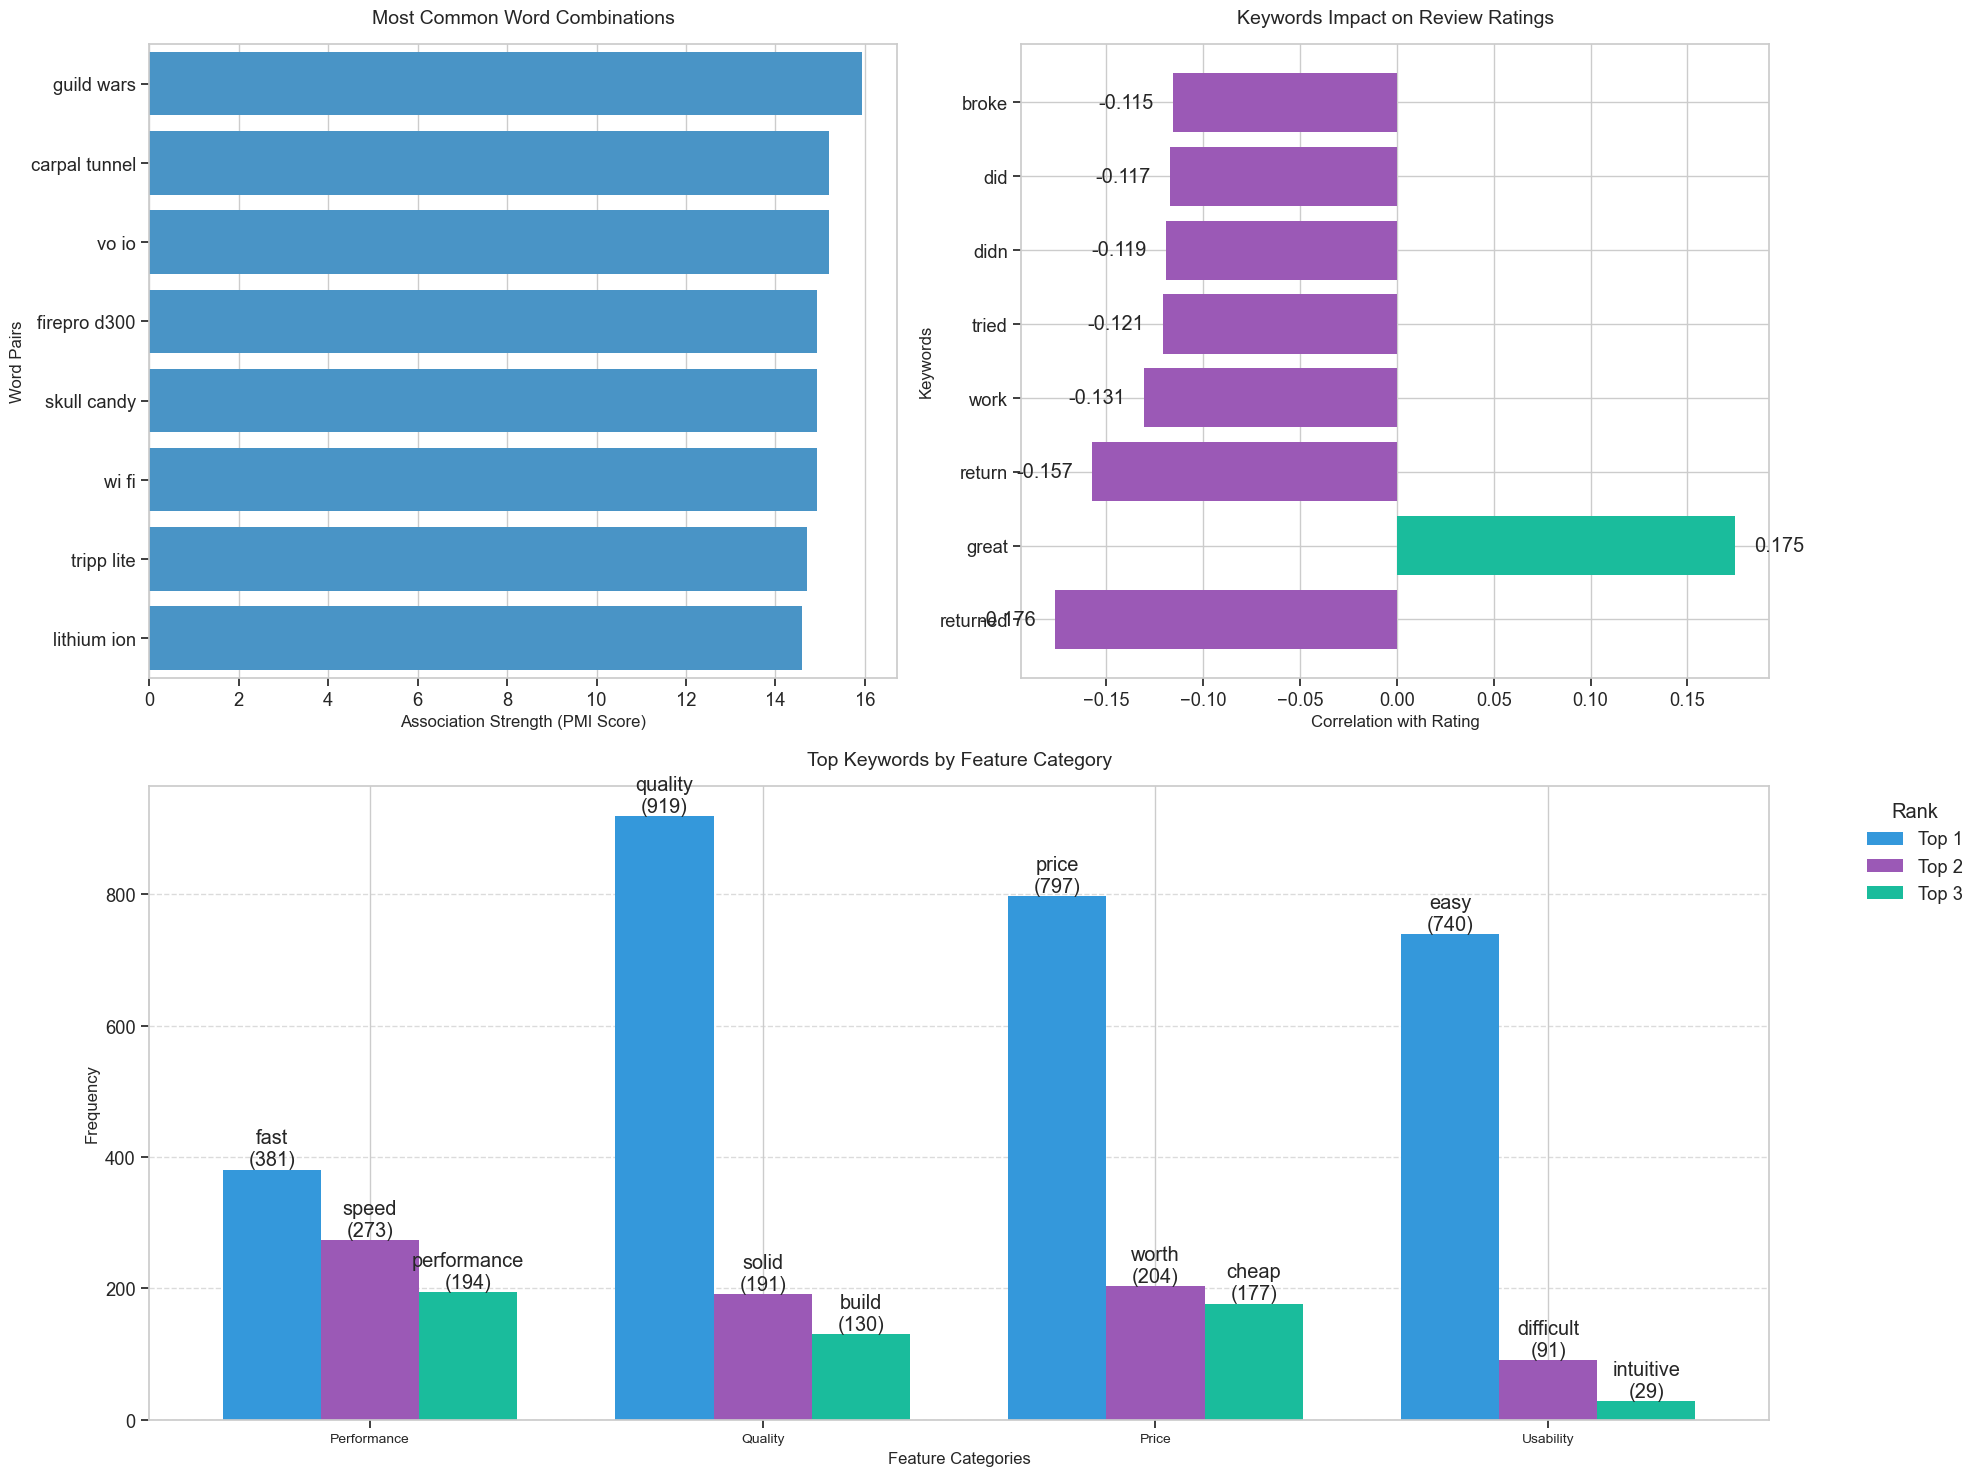

In [44]:
# Visualizations based on perform_advanced_keyword_analysis above
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Define color scheme
COLORS = {
    'primary': '#3498db',    # Blue
    'secondary': '#9b59b6',  # Purple
    'tertiary': '#1abc9c'    # Turquoise
}

def parse_analysis_file(file_path):
    """Parse the analysis text file and extract relevant data."""
    with open(file_path, 'r') as file:
        content = file.read()
    
    # Parse word pairs
    word_pairs_match = re.findall(r"\('(\w+)',\s*'(\w+)'\):\s*([\d.]+)", content)
    word_pairs = [(f"{w1} {w2}", float(score)) for w1, w2, score in word_pairs_match]
    
    # Parse impactful keywords
    impact_pattern = r"===\s*Most Impactful Keywords\s*===\n(.*?)\n\n"
    impact_section = re.search(impact_pattern, content, re.DOTALL).group(1)
    keyword_impact = []
    for line in impact_section.split('\n'):
        if line.strip():
            word, score = line.split(':')
            keyword_impact.append((word.strip(), float(score)))
    
    # Parse feature distributions
    features = {}
    categories = ['Performance', 'Quality', 'Price', 'Usability']
    
    for category in categories:
        pattern = f"{category} Keywords:(.*?)\n\n"
        match = re.search(pattern, content, re.DOTALL)
        if match:
            features[category] = {}
            for line in match.group(1).strip().split('\n'):
                if line.strip():
                    word, count = line.split(':')
                    features[category][word.strip()] = int(count)
    
    return word_pairs, keyword_impact, features

def create_visualizations(word_pairs, keyword_impact, features):
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("notebook", font_scale=1.2)
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Top Word Pairs Bar Chart
    ax1 = plt.subplot(221)
    pairs = [pair[0] for pair in word_pairs[:8]]
    scores = [pair[1] for pair in word_pairs[:8]]
    
    sns.barplot(x=scores, y=pairs, ax=ax1, color=COLORS['primary'])
    ax1.set_title('Most Common Word Combinations', fontsize=14, pad=15)
    ax1.set_xlabel('Association Strength (PMI Score)', fontsize=12)
    ax1.set_ylabel('Word Pairs', fontsize=12)
    
    # 2. Keyword Impact Chart
    ax2 = plt.subplot(222)
    impact_words = [word for word, score in keyword_impact[:8]]
    impact_scores = [score for word, score in keyword_impact[:8]]
    
    colors = [COLORS['tertiary'] if x > 0 else COLORS['secondary'] for x in impact_scores]
    bars = ax2.barh(impact_words, impact_scores, color=colors)
    ax2.set_title('Keywords Impact on Review Ratings', fontsize=14, pad=15)
    ax2.set_xlabel('Correlation with Rating', fontsize=12)
    ax2.set_ylabel('Keywords', fontsize=12)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        label_x = width + 0.01 if width >= 0 else width - 0.01
        ax2.text(label_x, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', 
                va='center',
                ha='left' if width >= 0 else 'right')
    
    # 3. Feature Distribution Chart
    ax3 = plt.subplot(212)
    
    # Prepare data for feature distribution
    categories = list(features.keys())
    n_categories = len(categories)
    n_bars = 3  # Top 3 words per category
    
    x = np.arange(n_categories)
    width = 0.25
    
    for i in range(n_bars):
        heights = []
        labels = []
        for category in categories:
            # Get top 3 words for each category
            top_words = sorted(features[category].items(), key=lambda x: x[1], reverse=True)
            if i < len(top_words):
                heights.append(top_words[i][1])
                labels.append(top_words[i][0])
            else:
                heights.append(0)
                labels.append('')
        
        positions = x + width * i
        bars = ax3.bar(positions, heights, width,
                      label=f'Top {i+1}',
                      color=COLORS['primary'] if i == 0 else COLORS['secondary'] if i == 1 else COLORS['tertiary'])
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            if heights[j] > 0:
                ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                        f'{labels[j]}\n({heights[j]})',
                        ha='center', va='bottom')
    
    ax3.set_title('Top Keywords by Feature Category', fontsize=14, pad=15)
    ax3.set_xlabel('Feature Categories', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(categories, fontsize=10)
    ax3.legend(title='Rank', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add grid
    ax3.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    return fig

def main():
    # Parse the file
    input_file = "../data/analysis/context_analysis.txt"
    word_pairs, keyword_impact, features = parse_analysis_file(input_file)
    
    # Create and save visualizations
    fig = create_visualizations(word_pairs, keyword_impact, features)
    # plt.savefig('sentiment_analysis_results.png', 
    #             dpi=300, 
    #             bbox_inches='tight',
    #             facecolor='white')
    # plt.close()

if __name__ == "__main__":
    main()

1. Most Common Word Combinations (Top Bar Chart):
- Shows strong word pairs that frequently appear together in reviews
- Top pairs include specific product names and technical terms:
  * "guild wars" (likely game-related)
  * "carpal tunnel" (ergonomic/health concern)
  * "vo io" (technical specification)
  * "firepro d300" (product model)
  * "skull candy" (brand name)
  * "wi fi" (common feature)
  * "tripp lite" (brand name)
  * "lithium ion" (battery type)
- High PMI scores (all above 14) indicate these pairs appear together much more frequently than by chance

1. Keywords Impact on Review Ratings (Middle Chart):
- Shows how words correlate with review ratings
- Positive correlation:
  * "great" has the strongest positive impact (0.175)
- Negative correlations:
  * "returned" has the strongest negative impact (-0.176)
  * "return," "work," "tried," "didn," "did," and "broke" all have moderate negative impacts
- This suggests product returns and functionality issues are major factors in negative reviews

1. Top Keywords by Feature Category (Bottom Chart):
- Shows frequency distribution of top words in each category
Performance:
  * "fast" (381 mentions)
  * "speed" (273 mentions)
  * "performance" (194 mentions)
Quality:
  * "quality" most mentioned (919)
  * "solid" (191 mentions)
  * "build" (130 mentions)
Price:
  * "price" (797 mentions)
  * "worth" (204 mentions)
  * "cheap" (177 mentions)
Usability:
  * "easy" (740 mentions)
  * "difficult" (91 mentions)
  * "intuitive" (29 mentions)

Key Insights:
- Technical specifications and brand names are commonly discussed together
- Product returns and functionality issues are strong indicators of negative reviews
- Quality and price are the most frequently discussed features
- Ease of use is important but discussed less frequently than other features

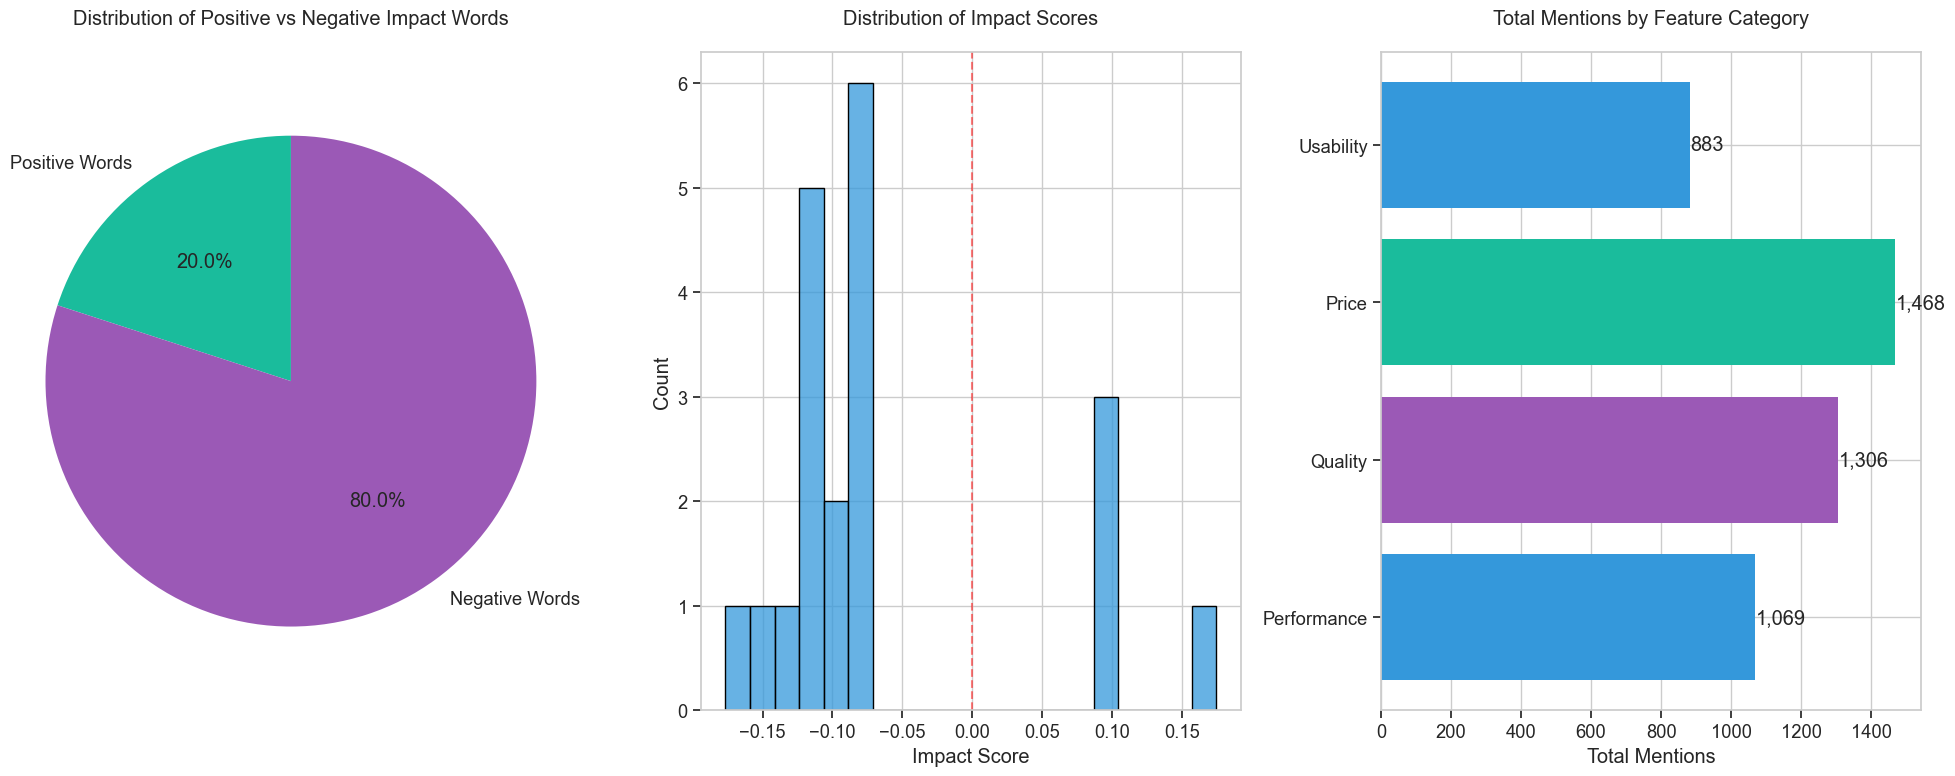

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Define color scheme
COLORS = {
    'primary': '#3498db',    # Blue
    'secondary': '#9b59b6',  # Purple
    'tertiary': '#1abc9c'    # Turquoise
}

def create_three_visualizations(keyword_impact, features):
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("notebook", font_scale=1.2)
    
    # Create figure with adjusted layout for three charts
    fig = plt.figure(figsize=(20, 8))
    
    # 1. Positive vs Negative Keywords Distribution (Pie Chart)
    ax1 = plt.subplot(131)
    positive_words = [(word, score) for word, score in keyword_impact if score > 0]
    negative_words = [(word, score) for word, score in keyword_impact if score < 0]
    
    labels = ['Positive Words', 'Negative Words']
    sizes = [len(positive_words), len(negative_words)]
    colors = [COLORS['tertiary'], COLORS['secondary']]
    
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
            startangle=90)
    ax1.axis('equal')
    ax1.set_title('Distribution of Positive vs Negative Impact Words', pad=20)
    
    # 2. Impact Score Distribution (Histogram)
    ax2 = plt.subplot(132)
    impact_scores = [score for _, score in keyword_impact]
    
    sns.histplot(impact_scores, bins=20, color=COLORS['primary'], ax=ax2)
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    ax2.set_title('Distribution of Impact Scores', pad=20)
    ax2.set_xlabel('Impact Score')
    ax2.set_ylabel('Count')
    
    # 3. Feature Category Comparison (Horizontal Bar Chart)
    ax3 = plt.subplot(133)
    
    # Calculate total mentions for each category
    category_totals = {}
    for category, words in features.items():
        category_totals[category] = sum(words.values())
    
    # Create horizontal bar chart
    categories = list(category_totals.keys())
    totals = list(category_totals.values())
    
    bars = ax3.barh(categories, totals, color=list(COLORS.values())[:len(categories)])
    ax3.set_title('Total Mentions by Feature Category', pad=20)
    ax3.set_xlabel('Total Mentions')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax3.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{int(width):,}',
                va='center')
    
    plt.tight_layout()
    return fig

def main():
    # Parse your existing data
    input_file = "../data/analysis/context_analysis.txt"
    word_pairs, keyword_impact, features = parse_analysis_file(input_file)
    
    # Create visualizations
    fig = create_three_visualizations(keyword_impact, features)
    plt.savefig('sentiment_analysis_three_charts.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white')
    
    # plt.close()

if __name__ == "__main__":
    main()

1. Distribution of Positive vs Negative Impact Words (Pie Chart):
- 80% of impactful words in reviews are negative
- Only 20% are positive words
- This suggests customers are more likely to use negative words with strong impact when writing reviews
- This could indicate that customers are more expressive when describing problems or dissatisfaction

2. Distribution of Impact Scores (Histogram):
- The histogram shows how strong the words' impacts are on ratings
- Negative scores (left of red dashed line) indicate words associated with lower ratings
- Positive scores (right of red dashed line) indicate words associated with higher ratings
- There's a concentration of moderately negative words (around -0.10)
- Few words have very strong impacts (either positive or negative)
- The distribution is slightly skewed toward negative impacts

3. Total Mentions by Feature Category (Horizontal Bar Chart):
- Price is the most discussed feature (1,468 mentions)
- Followed by Quality (1,306 mentions)
- Performance (1,069 mentions)
- Usability has the fewest mentions (883)
- This suggests customers are most concerned about price-related aspects of electronics products
- Quality and performance are also significant factors in reviews

Key Insights:
- While price gets the most mentions, the high proportion of negative impact words suggests many customers are expressing dissatisfaction
- The concentration of moderate negative impact scores suggests consistent but not extreme criticism
- The distribution across feature categories is relatively balanced, indicating customers consider multiple aspects when reviewing products